In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

['/device:CPU:0', '/device:GPU:0']


## Data : cifar 10

In [2]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(X_tot, y_tot), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=10)
y_tot=to_categorical(y_tot, num_classes=10)

print(X_tot.shape)
print(y_tot.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [3]:
#shuffle data and split data to generate validation data
shuffler = np.random.RandomState(seed=42).permutation(len(X_tot))
X_tot = X_tot[shuffler]
y_tot = y_tot[shuffler]
 
#validation data
X_val=X_tot[0:2000]
y_val=y_tot[0:2000]

X_train=X_tot[2000:]
y_train=y_tot[2000:]

In [16]:
def train(model,path):
    train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            width_shift_range=4, #+-8 pixel shift max
            height_shift_range=4)#+-8 pixel shift max

    reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                                  patience=5, min_lr=0.001, verbose=1)

    #Early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=10)
    # checkpoints
    checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])

    train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
    step_size_train=train_generator.n//train_generator.batch_size

    history=model.fit(train_generator,
                        steps_per_epoch=step_size_train,
                        epochs=200,
                        validation_data=(X_val,y_val),
                        callbacks=[reduce_lr,es,checkpoint])
    return history

# Residual block

In [5]:
from utils.evaluate_model import score
model = tf.keras.models.load_model('./full_models/cifar10/resnet_best.h5')
score(model,X_test,y_test,top_n=[3,5])

313/313 - 12s - loss: 0.7722 - acc: 0.8070
custom_resnet
model accuracy: 80.70%
top 3 accuracy: 95.85999846458435
top 5 accuracy: 98.7500011920929


# Standard SE Block

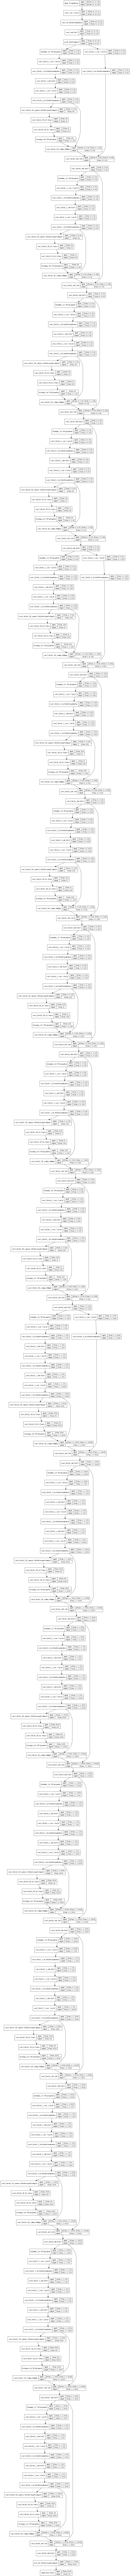

In [47]:
from utils.ablation_resnet import custom_resnet_ablation
resnet_46=custom_resnet_ablation(res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],ablation='standard',custom_input=(32,32,3),n_classes=10)
tf.keras.utils.plot_model(resnet_46, to_file='img/ablation_standard.png',show_shapes=True)

In [6]:
model = tf.keras.models.load_model('./full_models/cifar10/SE_resnet_best.h5')
score(model,X_test,y_test,top_n=[3,5])

313/313 - 13s - loss: 0.5569 - acc: 0.8261
SE_custom_resnet46
model accuracy: 82.61%
top 3 accuracy: 96.66000008583069
top 5 accuracy: 98.989999294281


#  Stage 1 

# Stage 2

# Stage 3